In [ ]:
import pandas as pd
import numpy as np

import seaborn as sns
from sklearn.metrics import r2_score
from sklearn.preprocessing import OneHotEncoder, LabelEncoder,StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, confusion_matrix, accuracy_score, ConfusionMatrixDisplay, RocCurveDisplay
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt , seaborn as sns , missingno as msno
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
## setting Jedha color palette as default
#pio.templates["jedha"] = go.layout.Template(
#    layout_colorway=["#4B9AC7", "#4BE8E0", "#9DD4F3", "#97FBF6", "#2A7FAF", "#23B1AB", "#0E3449", "#015955"]
#)
#pio.templates.default = "jedha"
pio.renderers.default = "svg" # to be replaced by "iframe" if working on JULIE
from IPython.display import display

In [ ]:
data = pd.read_csv('conversion_data_train.csv')
print('Set with labels (our train+test) :', data.shape)

Set with labels (our train+test) : (284580, 6)


EDA

In [ ]:
data.describe(include="all")

,country,age,new_user,source,total_pages_visited,converted
count,284580,284580.000000,284580.000000,284580,284580.000000,284580.000000
unique,4,NaN,NaN,3,NaN,NaN
top,US,NaN,NaN,Seo,NaN,NaN
freq,160124,NaN,NaN,139477,NaN,NaN
mean,NaN,30.564203,0.685452,NaN,4.873252,0.032258
std,NaN,8.266789,0.464336,NaN,3.341995,0.176685
min,NaN,17.000000,0.000000,NaN,1.000000,0.000000
25%,NaN,24.000000,0.000000,NaN,2.000000,0.000000
50%,NaN,30.000000,1.000000,NaN,4.000000,0.000000
75%,NaN,36.000000,1.000000,NaN,7.000000,0.000000


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284580 entries, 0 to 284579
Data columns (total 6 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   country              284580 non-null  object
 1   age                  284580 non-null  int64 
 2   new_user             284580 non-null  int64 
 3   source               284580 non-null  object
 4   total_pages_visited  284580 non-null  int64 
 5   converted            284580 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 13.0+ MB


nous avons aucune valeur manquante.

In [ ]:
print("Percentage of missing values: ")
display(100*data.isnull().sum()/data.shape[0])

Percentage of missing values: 


country                0.0
age                    0.0
new_user               0.0
source                 0.0
total_pages_visited    0.0
converted              0.0
dtype: float64

In [ ]:
# Is the target variable balanced ?
print('Percentage of converted persons in the dataset : ' , round(len(data[data['converted'] == 1]) / len(data) , 3) * 100 , '%')

Percentage of converted persons in the dataset :  3.2 %


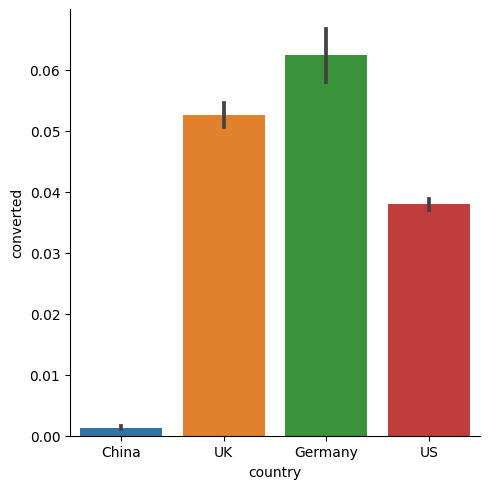

In [ ]:
sns.catplot(x="country", y="converted", kind="bar", data=data)

<ipython-input-10-f39328851ded>:1: FutureWarning:

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.



<Axes: >

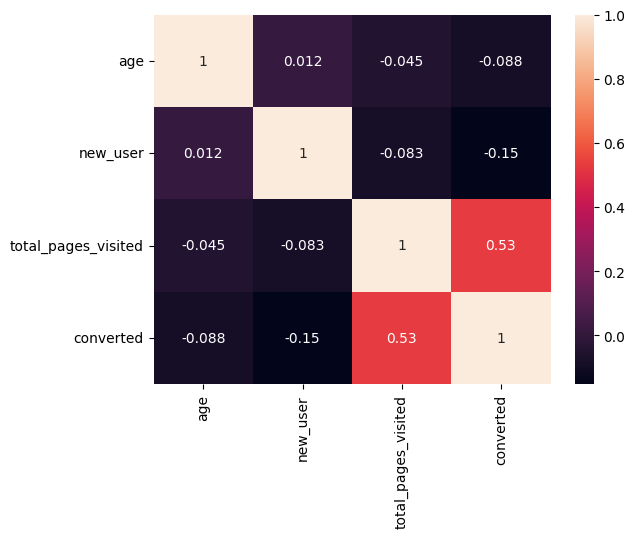

In [ ]:
correlation = data.corr()
sns.heatmap(correlation, annot=True)

In [ ]:
abs(correlation['converted']).sort_values(ascending = False) #What is the top 3 features we should keep to predict converted ?


converted              1.000000
total_pages_visited    0.529192
new_user               0.152115
age                    0.088265
Name: converted, dtype: float64

In [ ]:
# The dataset is quite big : you must create a sample of the dataset before making any visualizations !
data_sample = data.sample(10000)

In [ ]:
data_sample.head()

,country,age,new_user,source,total_pages_visited,converted
41800,US,34,0,Direct,7,0
249272,UK,31,1,Seo,2,0
176896,US,18,1,Direct,3,0
256245,US,23,1,Direct,13,0
138866,UK,25,1,Direct,3,0


PEPROSSESSING

In [ ]:
# Separate target variable Y from features X
print("Separating labels from features...")
features_list = ["new_user","country", "age","total_pages_visited"]
target_variable = "converted"

X = data.loc[:,features_list]
Y = data.loc[:,target_variable]

print("...Done.")
print()

print('Y : ')
print(Y.head())
print()
print('X :')
print(X.head())

Separating labels from features...
...Done.

Y : 
0    0
1    0
2    1
3    0
4    0
Name: converted, dtype: int64

X :
   new_user  country  age  total_pages_visited
0         1    China   22                    2
1         1       UK   21                    3
2         0  Germany   20                   14
3         1       US   23                    3
4         1       US   28                    3


In [ ]:
# Automatically detect names of numeric/categorical columns
numeric_features = []
categorical_features = []
for i,t in X.dtypes.iteritems():
    if ('float' in str(t)) or ('int' in str(t)) :
        numeric_features.append(i)
    else :
        categorical_features.append(i)

print('Found numeric features ', numeric_features)
print('Found categorical features ', categorical_features)

Found numeric features  ['new_user', 'age', 'total_pages_visited']
Found categorical features  ['country']


<ipython-input-17-0f0a515c43b5>:4: FutureWarning:

iteritems is deprecated and will be removed in a future version. Use .items instead.



In [ ]:
# Divide dataset Train set & Test set
print("Dividing into train and test sets...")
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=0)
print("...Done.")
print()

Dividing into train and test sets...
...Done.



In [ ]:
# Create pipeline for numeric features
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')), # missing values will be replaced by columns' mean
    ('scaler', StandardScaler())
])

In [ ]:
# Create pipeline for categorical features
categorical_transformer = Pipeline(
    steps=[
    ('encoder', OneHotEncoder(drop='first')) # first column will be dropped to avoid creating correlations between features
    ])

In [ ]:
# Use ColumnTransformer to make a preprocessor object that describes all the treatments to be done
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

In [ ]:
# Preprocessings on train set
print("Performing preprocessings on train set...")
print(X_train.head())
X_train = preprocessor.fit_transform(X_train)
print('...Done.')
print(X_train[0:5]) # MUST use this syntax because X_train is a numpy array and not a pandas DataFrame anymore
print()

# Preprocessings on test set
print("Performing preprocessings on test set...")
print(X_test.head())
X_test = preprocessor.transform(X_test) # Don't fit again !! The test set is used for validating decisions
# we made based on the training set, therefore we can only apply transformations that were parametered using the training set.
# Otherwise this creates what is called a leak from the test set which will introduce a bias in all your results.
print('...Done.')
print(X_test[0:5,:]) # MUST use this syntax because X_test is a numpy array and not a pandas DataFrame anymore
print()

Performing preprocessings on train set...
        new_user country  age  total_pages_visited
17050          1      US   29                    4
260342         0      US   23                    7
278164         1      UK   33                   11
268440         1   China   25                    5
157837         0      US   40                    1
...Done.
[[ 0.67687527 -0.19030813 -0.26094223  0.          0.          1.        ]
 [-1.47737706 -0.9161838   0.63598611  0.          0.          1.        ]
 [ 0.67687527  0.29360899  1.83189056  0.          1.          0.        ]
 [ 0.67687527 -0.67422524  0.03803388  0.          0.          0.        ]
 [-1.47737706  1.14046394 -1.15787057  0.          0.          1.        ]]

Performing preprocessings on test set...
        new_user  country  age  total_pages_visited
149371         1       US   20                    7
221325         1       US   31                    5
14016          0       US   28                    4
257982         1 

LOGISTIQUE REGRESSION

In [ ]:
# Train model
print("Train model...")
classifier = LogisticRegression()
classifier.fit(X_train, Y_train)
print("...Done.")

Train model...
...Done.


In [ ]:
# Predictions on training set
print("Predictions on training set...")
Y_train_pred = classifier.predict(X_train)
print("...Done.")
print(Y_train_pred)
print()

Predictions on training set...
...Done.
[0 0 0 ... 0 0 0]



In [ ]:
# Predictions on test set
print("Predictions on test set...")
Y_test_pred = classifier.predict(X_test)
print("...Done.")
print(Y_test_pred)
print()

Predictions on test set...
...Done.
[0 0 0 ... 0 0 0]



In [ ]:
# WARNING : Use the same score as the one that will be used by Kaggle !
# Here, the f1-score will be used to assess the performances on the leaderboard
print("f1-score on train set : ", f1_score(Y_train, Y_train_pred))
print("f1-score on test set : ", f1_score(Y_test, Y_test_pred))

f1-score on train set :  0.7631280695126558
f1-score on test set :  0.7566265060240963


MATRICE DE CONFUSION




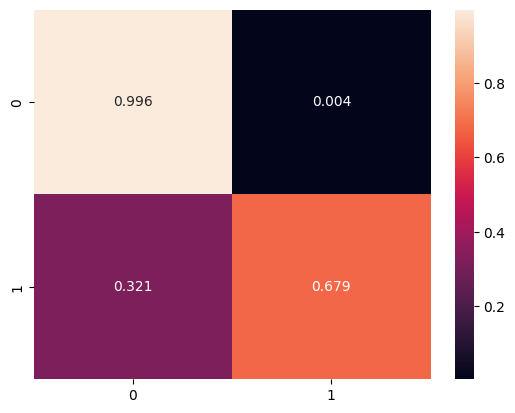

In [ ]:
import seaborn as sns
print('MATRICE DE CONFUSION')
print()
print()
cm = confusion_matrix(Y_test, Y_test_pred, normalize="true")
sns.heatmap(cm, annot=True, fmt=".3f");

En analysant les données de test, on observe que 99,6 % des non convertis ont été correctement classés comme tels, tandis que seulement 68 % des convertis ont été correctement classés comme tels. Cependant, il est important de noter un biais de 32 % où les convertis ont été classés à tort comme non convertis

PREPROSESSING

In [ ]:
# Separate target variable Y from features X
print("Separating labels from features...")
target_variable = "converted"

X = data.drop(target_variable, axis = 1)
Y = data.loc[:,target_variable]

print("...Done.")
print()

print('Y : ')
print(Y.head())
print()
print('X :')
print(X.head())

Separating labels from features...
...Done.

Y : 
0    0
1    0
2    1
3    0
4    0
Name: converted, dtype: int64

X :
   country  age  new_user  source  total_pages_visited
0    China   22         1  Direct                    2
1       UK   21         1     Ads                    3
2  Germany   20         0     Seo                   14
3       US   23         1     Seo                    3
4       US   28         1  Direct                    3


In [ ]:
# Automatically detect names of numeric/categorical columns
numeric_features = []
categorical_features = []
for i,t in X.dtypes.iteritems():
    if ('float' in str(t)) or ('int' in str(t)) :
        numeric_features.append(i)
    else :
        categorical_features.append(i)

print('Found numeric features ', numeric_features)
print('Found categorical features ', categorical_features)

Found numeric features  ['age', 'new_user', 'total_pages_visited']
Found categorical features  ['country', 'source']


<ipython-input-29-0f0a515c43b5>:4: FutureWarning:

iteritems is deprecated and will be removed in a future version. Use .items instead.



In [ ]:
# Divide dataset Train set & Test set
print("Dividing into train and test sets...")
# WARNING : don't forget stratify=Y for classification problems
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=0, stratify = Y)
print("...Done.")
print()

Dividing into train and test sets...
...Done.



In [ ]:
# Create pipeline for numeric features
numeric_transformer = SimpleImputer(strategy='mean') # missing values will be replaced by columns' mean
# Create pipeline for categorical features
categorical_transformer = OneHotEncoder(drop='first') # no missing values in categorical data, so we only need the OHE

In [ ]:
# Preprocessings on train set
print("Performing preprocessings on train set...")
#print(X_train.head())
X_train = preprocessor.fit_transform(X_train)
print('...Done.')
print(X_train[0:5]) # MUST use this syntax because X_train is a numpy array and not a pandas DataFrame anymore
print()
# Label encoding
print("Encoding labels...")
print(Y_train.head())
encoder = LabelEncoder()
Y_train = encoder.fit_transform(Y_train)
print("...Done")
print(Y_train[0:5])

# Preprocessings on test set
print("Performing preprocessings on test set...")
print(X_test.head())
X_test = preprocessor.transform(X_test) # Don't fit again !! The test set is used for validating decisions
# we made based on the training set, therefore we can only apply transformations that were parametered using the training set.
# Otherwise this creates what is called a leak from the test set which will introduce a bias in all your results.
print('...Done.')
print(X_test[0:5,:]) # MUST use this syntax because X_test is a numpy array and not a pandas DataFrame anymore
print()
# Label encoding
print("Encoding labels...")
print(Y_test[0:5])
Y_test = encoder.transform(Y_test)
print("...Done")
print(Y_test[0:5])

Performing preprocessings on train set...
...Done.
[[ 0.67651656 -1.3990984  -1.15935344  0.          0.          0.        ]
 [ 0.67651656  0.29299544  0.03743241  0.          0.          1.        ]
 [ 0.67651656  2.46854467 -0.86015697  0.          0.          1.        ]
 [-1.47816042 -1.64082609 -1.15935344  0.          0.          0.        ]
 [ 0.67651656 -0.31132378  0.03743241  0.          0.          0.        ]]

Encoding labels...
137434    0
112323    0
143261    0
162328    0
158039    0
Name: converted, dtype: int64
...Done
[0 0 0 0 0]
Performing preprocessings on test set...
       country  age  new_user  source  total_pages_visited
138303      UK   34         1     Ads                    1
133130      UK   32         0     Ads                    5
245758      US   44         1     Ads                    1
185267      US   35         1  Direct                    1
177637      US   29         1  Direct                    3
...Done.
[[ 0.67651656  0.41385929 -1.15935344  

**RANDOM FOREST**

In [ ]:
# Perform grid search
print("Grid search...")
classifier = RandomForestClassifier()

# Grid of values to be tested
params = {
    'max_depth': [2, 4, 6, 8, 10],
    'min_samples_leaf': [1, 2, 5],
    'min_samples_split': [2, 4, 8],
    'n_estimators': [10, 20, 40, 60, 80, 100]
}
gridsearch = GridSearchCV(classifier, param_grid = params, cv = 3) # cv : the number of folds to be used for CV
gridsearch.fit(X_train, Y_train)
print("...Done.")
print("Best hyperparameters : ", gridsearch.best_params_)
print("Best validation accuracy : ", gridsearch.best_score_)

Grid search...
...Done.
Best hyperparameters :  {'max_depth': 8, 'min_samples_leaf': 2, 'min_samples_split': 8, 'n_estimators': 40}
Best validation accuracy :  0.9861857825567503


In [ ]:
# Predictions on training set
print("Predictions on training set...")
Y_train_pred = gridsearch.predict(X_train)
print("...Done.")
print(Y_train_pred)
print()

# It's also possible to get the probabilities estimated by the model:
print("Probabilities on training set...")
Y_train_proba = gridsearch.predict_proba(X_train)
print("...Done.")
print(Y_train_proba)
print()

Predictions on training set...
...Done.
[0 0 0 ... 0 0 0]

Probabilities on training set...
...Done.
[[9.99325426e-01 6.74573769e-04]
 [9.98199838e-01 1.80016199e-03]
 [9.99093592e-01 9.06408081e-04]
 ...
 [9.93428045e-01 6.57195451e-03]
 [9.18766554e-01 8.12334463e-02]
 [9.96619852e-01 3.38014762e-03]]



In [ ]:
# Predictions on test set
print("Predictions on test set...")
Y_test_pred = gridsearch.predict(X_test)
print("...Done.")
print(Y_test_pred)
print()

# It's also possible to get the probabilities estimated by the model:
print("Probabilities on test set...")
Y_test_proba = gridsearch.predict_proba(X_test)
print("...Done.")
print(Y_test_proba)
print()

Predictions on test set...
...Done.
[0 0 0 ... 0 0 0]

Probabilities on test set...
...Done.
[[9.99240704e-01 7.59296002e-04]
 [9.93663829e-01 6.33617077e-03]
 [9.99020131e-01 9.79868836e-04]
 ...
 [9.90947022e-01 9.05297844e-03]
 [9.97966286e-01 2.03371368e-03]
 [9.97406671e-01 2.59332882e-03]]



In [ ]:
# Print scores
print("accuracy on training set : ", accuracy_score(Y_train, Y_train_pred))
print("accuracy on test set : ", accuracy_score(Y_test, Y_test_pred))
print()

print("f1-score on training set : ", f1_score(Y_train, Y_train_pred))
print("f1-score on test set : ", f1_score(Y_test, Y_test_pred))
print()

accuracy on training set :  0.9866162414786703
accuracy on test set :  0.9852062688874833

f1-score on training set :  0.7714692867321683
f1-score on test set :  0.7479041916167664



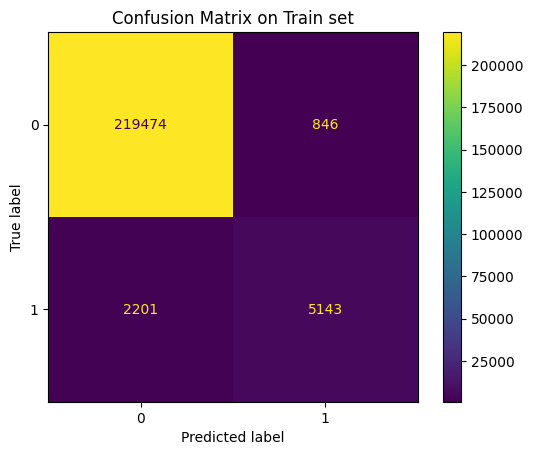

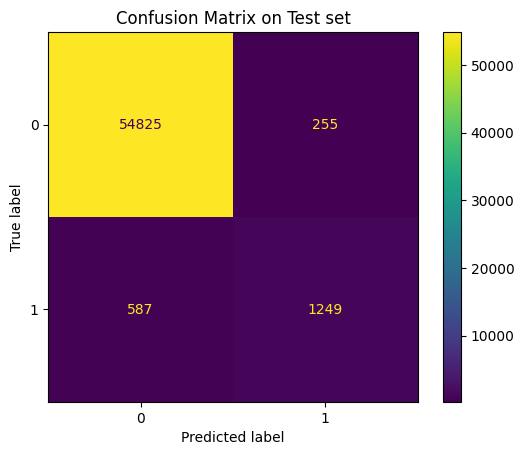

In [ ]:
# Visualize confusion matrices
_ , ax = plt.subplots() # Get subplot from matplotlib
ax.set(title="Confusion Matrix on Train set") # Set a title that we will add into ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator(gridsearch, X_train, Y_train, ax=ax) # ConfusionMatrixDisplay from sklearn
plt.show()

_ , ax = plt.subplots() # Get subplot from matplotlib
ax.set(title="Confusion Matrix on Test set") # Set a title that we will add into ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator(gridsearch, X_test, Y_test, ax=ax) # ConfusionMatrixDisplay from sklearn
plt.show()

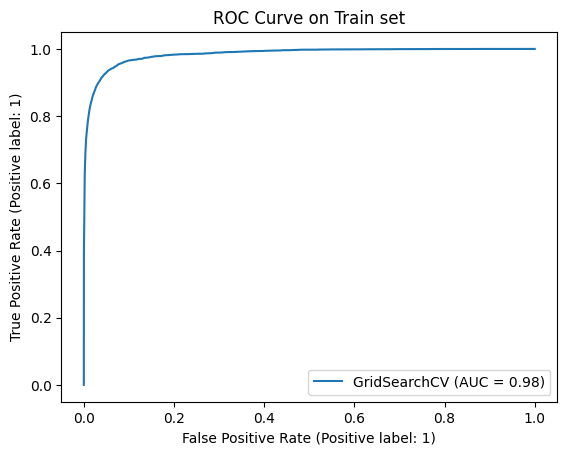

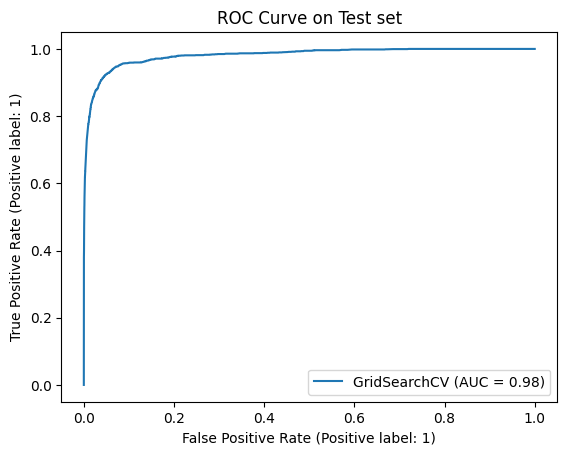

In [ ]:
# Visualize ROC curves
_ , ax = plt.subplots() # Get subplot from matplotlib
ax.set(title="ROC Curve on Train set") # Set a title that we will add into ConfusionMatrixDisplay
RocCurveDisplay.from_estimator(gridsearch, X_train, Y_train, ax=ax) # RocCurveDisplay from sklearn
plt.show()

_ , ax = plt.subplots() # Get subplot from matplotlib
ax.set(title="ROC Curve on Test set") # Set a title that we will add into ConfusionMatrixDisplay
RocCurveDisplay.from_estimator(gridsearch, X_test, Y_test, ax=ax) # RocCurveDisplay from sklearn
plt.show()